<a href="https://colab.research.google.com/github/katiemartinezz/457_Machine_Maintenance/blob/main/457_Machine_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Failure Predictor**

This model will predict whether a machine will fail based on factors such as vibration levels, temperature, and operational hours.

# Set Up

In [1]:
# Install dependencies as needed:
!pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Set the path to the file you'd like to load
file_path = "Large_Industrial_Pump_Maintenance_Dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "selonamaris/large-industrial-pump-maintenance-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("\nFirst 3 records:\n", df.head(3))


<ipython-input-1-2dbadd3b136d>:19: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


100%|██████████| 2.19M/2.19M [00:00<00:00, 28.5MB/s]



First 3 records:
    Pump_ID  Temperature  Vibration    Pressure  Flow_Rate          RPM  \
0        2   127.508350   2.369397  136.021029   6.501492  1444.191922   
1        4    88.975185   4.541126  147.516973   7.001516  1004.802496   
2        3    61.832325   2.542112  220.858577   8.824368  2597.662712   

   Operational_Hours  Maintenance_Flag  
0        3966.793672                 1  
1        3673.288933                 0  
2        5489.061016                 1  


In [ ]:
from sklearn.model_selection import GridSearchCV

# Pre-process: Split the data - Normalize

# Seperate X and y
X = df[['Vibration', 'Temperature', 'Operational_Hours']]  # Features
y = df['Maintenance_Flag']  # Labels (0 = working, 1 = failure)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter grid
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Create a KNN model
knn_model = KNeighborsClassifier()

# Grid Search with cross-validation
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Predict using the best model
best_knn_model = grid_search.best_estimator_
y_pred_best = best_knn_model.predict(X_test_scaled)

# Evaluate the model
final_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Final Test Set Accuracy: {final_accuracy:.4f}")


Best parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'weights': 'uniform'}
Best cross-validation accuracy: 0.5032
Final Test Set Accuracy: 0.5032


In [2]:
print(df.columns)

Index(['Pump_ID', 'Temperature', 'Vibration', 'Pressure', 'Flow_Rate', 'RPM',
       'Operational_Hours', 'Maintenance_Flag'],
      dtype='object')


In [3]:
# Interaction features
#df['Vibration_Temperature'] = df['Vibration'] * df['Temperature'] # A machine might be more likely to fail if both vibration and temperature are high, or they could work together to indicate a specific failure mode.
#df['Vibration_Operational_Hours'] = df['Vibration'] * df['Operational_Hours'] # If the vibration increases with time, it might indicate a specific wear-and-tear pattern.
#df['Temperature_Operational_Hours'] = df['Temperature'] * df['Operational_Hours'] # Higher operational hours might lead to increased temperatures due to prolonged usage.

# Group by Pump_ID and Maintenance_Flag, and calculate aggregated statistics
aggregated_features = df.groupby(['Pump_ID', 'Maintenance_Flag'])[['Vibration', 'Temperature', 'Operational_Hours']].agg(
    ['mean', 'std']).reset_index()

# Flatten the column multi-index and add underscores only to the feature columns
aggregated_features.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in aggregated_features.columns.values]

# Merge the aggregated features back into the original dataframe using the correct column names
df = df.merge(aggregated_features, on=['Pump_ID', 'Maintenance_Flag'], how='left')

# Display the new features
print(df.head())

   Pump_ID  Temperature  Vibration    Pressure  Flow_Rate          RPM  \
0        2   127.508350   2.369397  136.021029   6.501492  1444.191922   
1        4    88.975185   4.541126  147.516973   7.001516  1004.802496   
2        3    61.832325   2.542112  220.858577   8.824368  2597.662712   
3        3   106.250344   2.834452  145.817091  16.283512  2280.926281   
4        2    84.815865   3.119709  235.476221   8.385183  2594.131667   

   Operational_Hours  Maintenance_Flag  Vibration_mean  Vibration_std  \
0        3966.793672                 1        2.564630       1.421029   
1        3673.288933                 0        2.553701       1.419771   
2        5489.061016                 1        2.506272       1.436863   
3        3134.783015                 0        2.510008       1.432152   
4         761.533173                 1        2.564630       1.421029   

   Temperature_mean  Temperature_std  Operational_Hours_mean  \
0         99.003579        29.355282             498

In [4]:

needed = df
# Preprocess the data
X = needed.drop(['Pressure', 'Flow_Rate', 'RPM', 'Maintenance_Flag'], axis=1)  # Features
y = df['Maintenance_Flag']  # Labels (0 = working, 1 = failure)

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

# Predict on the test set and evaluate accuracy
y_pred = knn_model.predict(X_test_scaled)

# Train the final model using the best k
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

# Predict on the test set and evaluate accuracy
y_pred = knn_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {final_accuracy:.4f}")



Test Set Accuracy: 1.0000


# Visualize

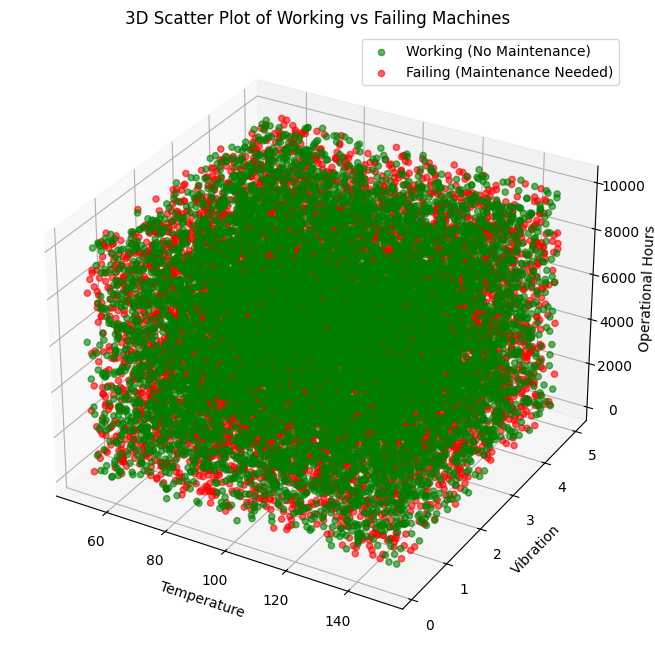

In [5]:
# Scatter Plot of working vs failing machines

from mpl_toolkits.mplot3d import Axes3D

# Plotting the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for working machines (No Maintenance)
ax.scatter(df[df['Maintenance_Flag'] == 0]['Temperature'],
            df[df['Maintenance_Flag'] == 0]['Vibration'],
            df[df['Maintenance_Flag'] == 0]['Operational_Hours'],
            color='green', label='Working (No Maintenance)', alpha=0.6)

# Scatter plot for failing machines (Maintenance Needed)
ax.scatter(df[df['Maintenance_Flag'] == 1]['Temperature'],
            df[df['Maintenance_Flag'] == 1]['Vibration'],
            df[df['Maintenance_Flag'] == 1]['Operational_Hours'],
            color='red', label='Failing (Maintenance Needed)', alpha=0.6)

# Labels and title
ax.set_xlabel('Temperature')
ax.set_ylabel('Vibration')
ax.set_zlabel('Operational Hours')
ax.set_title('3D Scatter Plot of Working vs Failing Machines')

# Show the legend
ax.legend()

# Show the plot
plt.show()



# Correlation Matrix

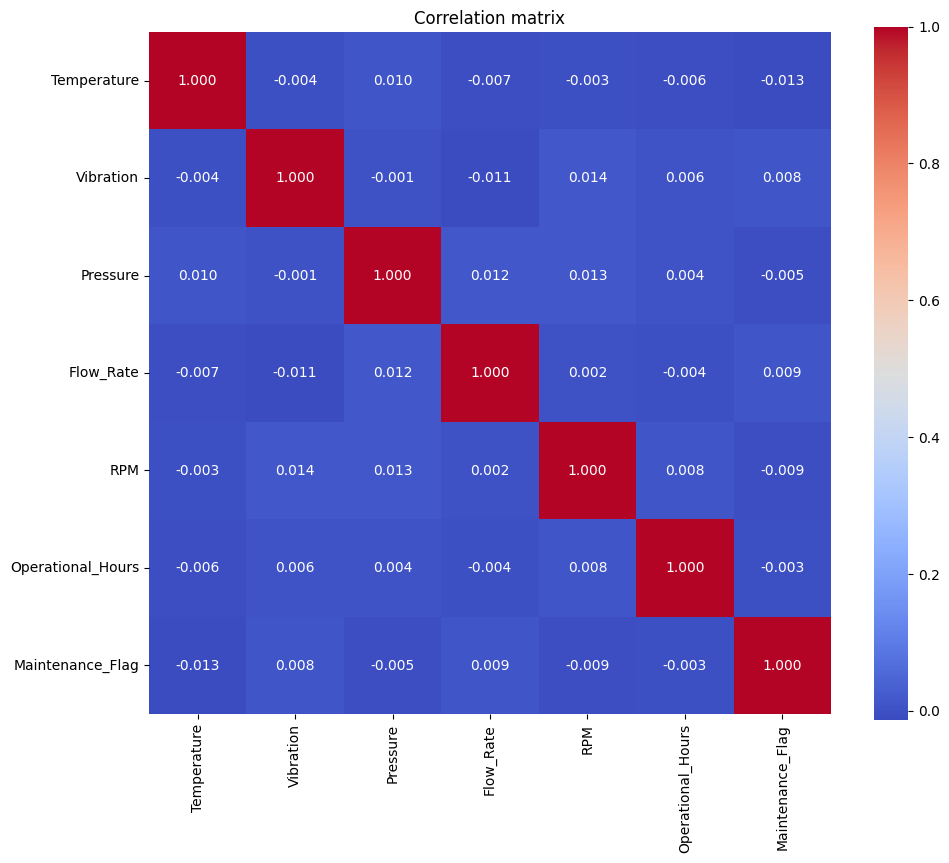

<Figure size 640x480 with 0 Axes>

In [ ]:
# Creating the correlation matrix
import seaborn as sns

correl_m = df.drop(["Pump_ID"], axis=1).corr(numeric_only=True)

plt.figure(figsize=(11, 9))

sns.heatmap(correl_m, annot=True, cmap='coolwarm', fmt=".3f", square=True, cbar_kws={"shrink": 1.0})

plt.title("Correlation matrix")

plt.show()

plt.tight_layout()

plt.show()

# Since we have low correlation between features, our data has a reduced multi-collinearity.